# Temperature on Electricity Demand (New England)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings

%matplotlib inline

#For warning surpression
warnings.filterwarnings("ignore", category=FutureWarning)
#To reactivate warning
# warnings.filterwarnings("default", category=FutureWarning)

## Background
Rough skeleton

1. Talk about electcity market 
2. Talk about heating and how its fractured
3. Talk about Schaffer paper and exisitng literature 
4. Motivations into what why we are looking into this and what the plan is 

## Electricity Demand (System Load)

https://www.iso-ne.com/isoexpress/

In [2]:
states = ['ISONE CA', 'ME', 'NH', 'VT', 'CT', 'RI', 'SEMASS' ,'WCMASS', 'NEMASSBOST']

state_dfs = [pd.DataFrame(columns=['Date', 'Hour', 'Demand', 'Temperature']) for _ in states]

#### DO NOT TOUCH (Cleaning for final project)

In [3]:
# for year in range(2011, 2018):
#     path = f"data/demand/{year}_smd_hourly.xls"
#     if year >= 2016:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hr_End', 'RT_Demand', 'Dry_Bulb']]
#             state_df = state_df.rename(columns = {'Hr_End' : 'Hour', 'RT_Demand' : 'Demand', 'Dry_Bulb' : 'Temperature'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd-bb-yy')
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
#     else:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hour', 'DEMAND', 'DryBulb']]
#             state_df = state_df.rename(columns = {'DEMAND' : 'Demand', 'DryBulb' : 'Temperature'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd/mm/yy')
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
            
# for i in range(len(state_dfs)):
#     #Set index as datetime
#     state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
#     state_dfs[i] = state_dfs[i].set_index('Datetime')
    
#     #Add Year column
#     state_dfs[i]['Year'] = pd.to_datetime(state_dfs[i]['Date']).dt.year
#     columns = ['Year'] + [col for col in state_dfs[i].columns if col != 'Year']
#     state_dfs[i] = state_dfs[i][columns]
    
#     #Remove all rows with 0 demand
#     state_dfs[i] = state_dfs[i][state_dfs[i]['Demand'] != 0]

#### Continue

In [4]:
state_names = ['isone_ca', 'me', 'nh', 'vt', 'ct', 'ri', 'sema', 'wcma', 'nema']

state_names_full = ['ISO-NE Control Area', 'Maine', 'New Hampshire', 'Vermont',
                    'Connecticut', 'Rhode Island', 'SouthEastern Massachusetts',
                    'Western & Central Massachusetts', 'NorthEastern Massachusetts & Boston']

In [5]:
for i in range(len(state_names)):
    path = f"data/Others/demand/{state_names[i]}.csv"
    state_dfs[i] = pd.read_csv(path)
    state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
    state_dfs[i] = state_dfs[i].set_index('Datetime')
    state_dfs[i]["Date"] = pd.to_datetime(state_dfs[i]["Date"])
    state_dfs[i]["Region"] = state_names_full[i]

In [6]:
state_dfs[1]

,Year,Date,Hour,Demand,Temperature,Region
Datetime,,,,,,
2011-01-01 01:00:00,2011,2011-01-01,1,1048.000,31,Maine
2011-01-01 02:00:00,2011,2011-01-01,2,1000.000,31,Maine
2011-01-01 03:00:00,2011,2011-01-01,3,964.000,32,Maine
2011-01-01 04:00:00,2011,2011-01-01,4,954.000,35,Maine
2011-01-01 05:00:00,2011,2011-01-01,5,960.000,34,Maine
...,...,...,...,...,...,...
2017-12-31 20:00:00,2017,2017-12-31,20,1696.392,2,Maine
2017-12-31 21:00:00,2017,2017-12-31,21,1652.438,1,Maine
2017-12-31 22:00:00,2017,2017-12-31,22,1577.769,0,Maine


In [7]:
big_state_df = pd.concat(state_dfs[1:], ignore_index=False)

big_state_df

,Year,Date,Hour,Demand,Temperature,Region
Datetime,,,,,,
2011-01-01 01:00:00,2011,2011-01-01,1,1048.000,31,Maine
2011-01-01 02:00:00,2011,2011-01-01,2,1000.000,31,Maine
2011-01-01 03:00:00,2011,2011-01-01,3,964.000,32,Maine
2011-01-01 04:00:00,2011,2011-01-01,4,954.000,35,Maine
2011-01-01 05:00:00,2011,2011-01-01,5,960.000,34,Maine
...,...,...,...,...,...,...
2017-12-31 20:00:00,2017,2017-12-31,20,3716.054,9,NorthEastern Massachusetts & Boston
2017-12-31 21:00:00,2017,2017-12-31,21,3619.467,8,NorthEastern Massachusetts & Boston
2017-12-31 22:00:00,2017,2017-12-31,22,3512.155,7,NorthEastern Massachusetts & Boston


Text(0.5, 1.0, 'Electricity Demand on Temperature (Entire ISO-NE)')

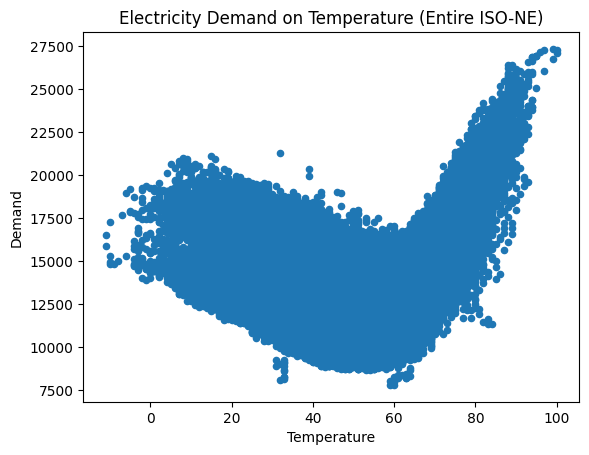

In [8]:
state_dfs[0].plot.scatter('Temperature', 'Demand')
plt.title('Electricity Demand on Temperature (Entire ISO-NE)')

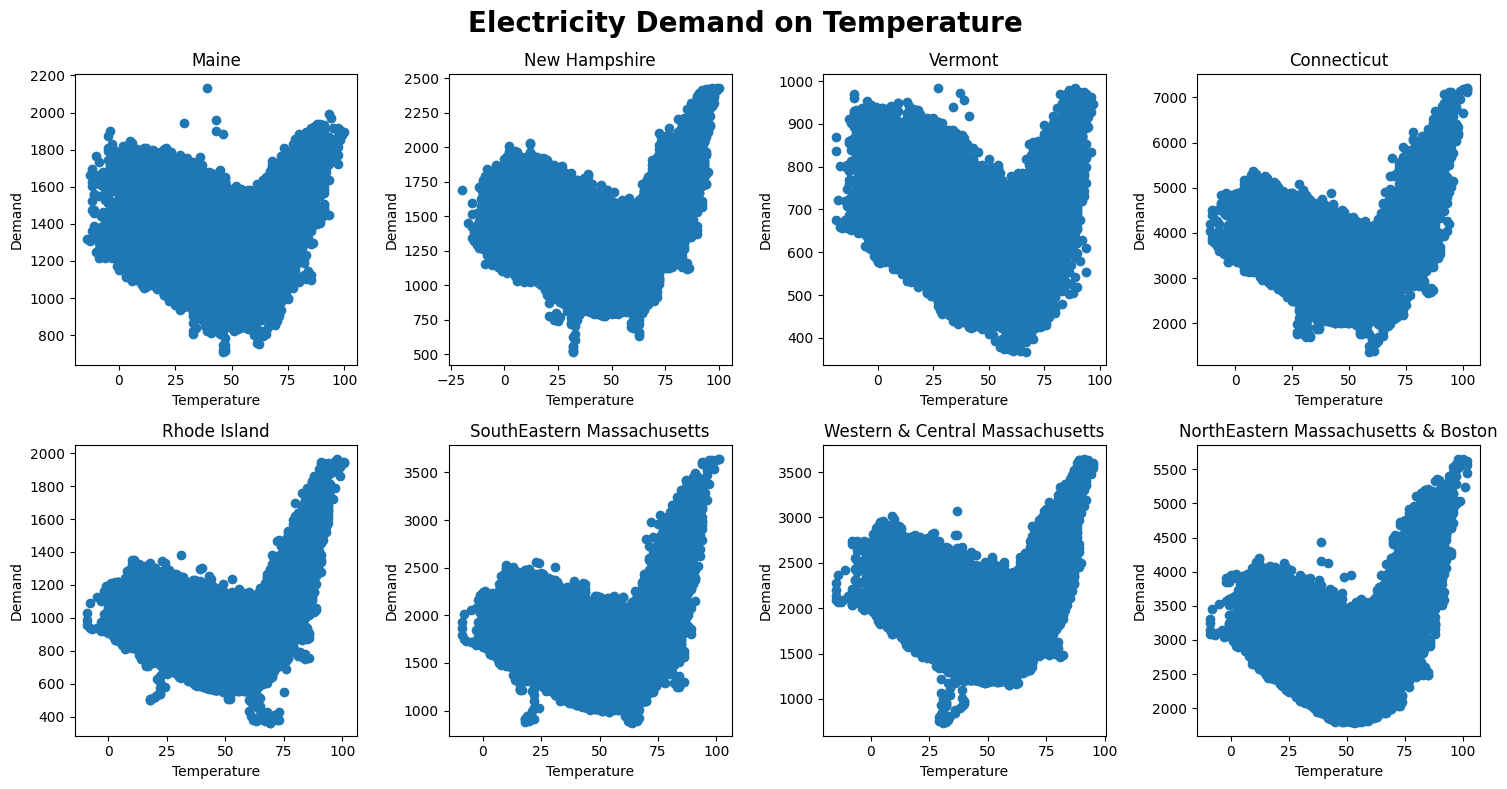

In [26]:
# Assuming `state_dfs` is a list of 8 DataFrames and `state_names` is a list of 8 titles
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):
    axes[i].scatter(df['Temperature'], df['Demand'])
    axes[i].set_title(name)
    axes[i].set_ylabel('Demand')
    axes[i].set_xlabel('Temperature')

fig.suptitle('Electricity Demand on Temperature', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

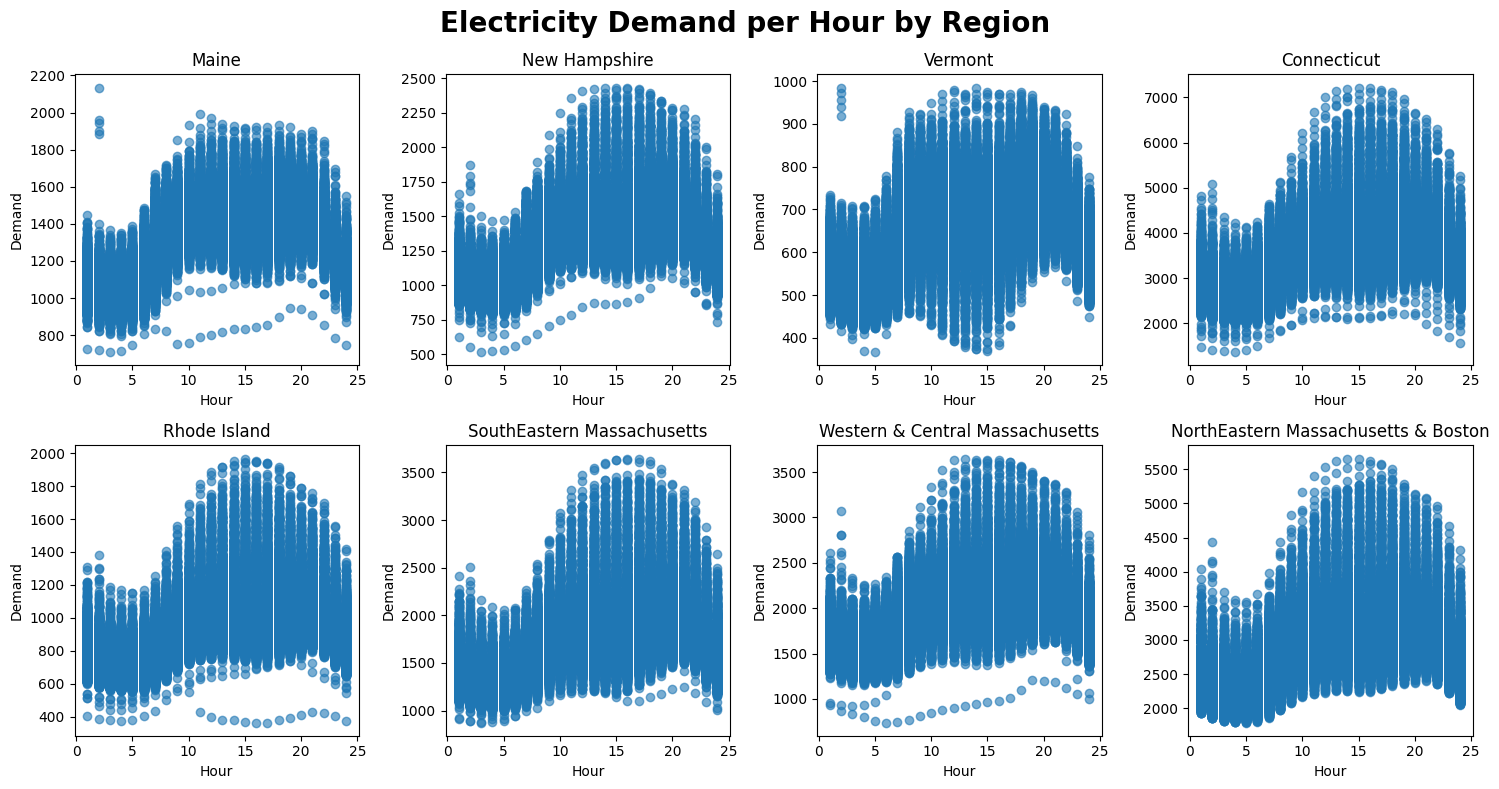

In [34]:
# Assuming `state_dfs` is a list of 8 DataFrames and `state_names_full` is a list of 8 titles
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):
    axes[i].scatter(df['Hour'], df['Demand'], alpha = 0.6)
    axes[i].set_title(name)
    axes[i].set_ylabel('Demand')
    axes[i].set_xlabel('Hour')
    # axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

fig.suptitle('Electricity Demand per Hour by Region', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Natural Gas Prices

https://www.eia.gov/dnav/ng/ng_pri_sum_a_EPG0_PG1_DMcf_m.htm

We control for natural gas prices because 

In [10]:
ng = pd.read_excel('data/NG_PRI_SUM_A_EPG0_PG1_DMCF_M.xls', sheet_name = 'Data 1',
                   skiprows = 2)

ng = ng[['Date', 'Natural Gas Citygate Price in Connecticut (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Maine (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Massachusetts (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in New Hampshire (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Rhode Island (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Vermont (Dollars per Thousand Cubic Feet)']]

ng.columns = ['Date', 'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']

ng = ng[(ng['Date'] >= '2011-01-01') & (ng['Date'] <= '2017-12-31')]

ng['year_month'] = ng['Date'].dt.to_period('M')

ng

,Date,Connecticut,Maine,Massachusetts,New Hampshire,Rhode Island,Vermont,year_month
456,2011-01-15,5.74,7.59,6.70,8.06,7.82,7.60,2011-01
457,2011-02-15,5.93,7.24,6.90,7.22,7.62,7.72,2011-02
458,2011-03-15,5.66,8.65,6.57,8.30,7.03,8.04,2011-03
459,2011-04-15,5.87,7.53,7.25,7.72,7.09,8.69,2011-04
460,2011-05-15,6.67,9.97,7.84,7.95,9.80,8.87,2011-05
...,...,...,...,...,...,...,...,...
535,2017-08-15,5.79,6.09,9.24,7.41,2.34,4.44,2017-08
536,2017-09-15,5.66,5.66,8.86,8.23,2.29,4.48,2017-09
537,2017-10-15,4.22,6.17,6.28,5.29,2.21,4.56,2017-10
538,2017-11-15,3.71,4.99,4.60,4.82,2.20,4.70,2017-11


In [11]:
for i in range(len(state_dfs)):
    state_dfs[i]['year_month'] = state_dfs[i]['Date'].dt.to_period('M')
    #All New England - no NG price data
    if i == 0:
        state_dfs[i].drop(columns = ['year_month'], inplace = True)
        continue
    #Maine
    elif i == 1:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Maine']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Maine': 'Natural Gas Price'})
    #New Hampsphire
    elif i == 2:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'New Hampshire']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'New Hampshire': 'Natural Gas Price'})
    #Vermont
    elif i == 3:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Vermont']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Vermont': 'Natural Gas Price'})
    #Connecticut
    elif i == 4:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Connecticut']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Connecticut': 'Natural Gas Price'})
    #Rhode Island
    elif i == 5:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Rhode Island']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Rhode Island': 'Natural Gas Price'})
    #Massachusetts
    else:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Massachusetts']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Massachusetts': 'Natural Gas Price'})
    state_dfs[i].drop(columns = ['year_month'], inplace = True)

In [12]:
state_dfs[1]

,Year,Date,Hour,Demand,Temperature,Region,Natural Gas Price
0,2011,2011-01-01,1,1048.000,31,Maine,7.59
1,2011,2011-01-01,2,1000.000,31,Maine,7.59
2,2011,2011-01-01,3,964.000,32,Maine,7.59
3,2011,2011-01-01,4,954.000,35,Maine,7.59
4,2011,2011-01-01,5,960.000,34,Maine,7.59
...,...,...,...,...,...,...,...
61358,2017,2017-12-31,20,1696.392,2,Maine,7.90
61359,2017,2017-12-31,21,1652.438,1,Maine,7.90
61360,2017,2017-12-31,22,1577.769,0,Maine,7.90
61361,2017,2017-12-31,23,1523.502,-1,Maine,7.90


### Generation Mix

https://www.iso-ne.com/isoexpress/web/reports/operations/-/tree/daily-gen-fuel-type

### Elasticity

In [13]:
pct_change_dfs = []

for i in range(len(state_dfs)):
    pct_change_df = state_dfs[i].copy()
    
    # Calculate percentage changes for Demand and Temperature
    pct_change_df['Demand_pct_change'] = pct_change_df['Demand'].pct_change()
    pct_change_df['Temperature_pct_change'] = pct_change_df['Temperature'].pct_change()

    # Calculate Elasticity
    pct_change_df['Elasticity'] = pct_change_df['Demand_pct_change'] / pct_change_df['Temperature_pct_change']

    # Remove rows with NaN or infinite Elasticity values
    pct_change_df = pct_change_df.dropna(subset=['Elasticity'])
    # pct_change_df = pct_change_df[~pct_change_df['Elasticity'].isin([np.inf, -np.inf])]

    # Append the modified DataFrame to pct_change_dfs
    pct_change_dfs.append(pct_change_df)

In [14]:
pct_change_dfs[1]

,Year,Date,Hour,Demand,Temperature,Region,Natural Gas Price,Demand_pct_change,Temperature_pct_change,Elasticity
1,2011,2011-01-01,2,1000.000,31,Maine,7.59,-0.045802,0.000000,-inf
2,2011,2011-01-01,3,964.000,32,Maine,7.59,-0.036000,0.032258,-1.116000
3,2011,2011-01-01,4,954.000,35,Maine,7.59,-0.010373,0.093750,-0.110650
4,2011,2011-01-01,5,960.000,34,Maine,7.59,0.006289,-0.028571,-0.220126
5,2011,2011-01-01,6,983.000,33,Maine,7.59,0.023958,-0.029412,-0.814583
...,...,...,...,...,...,...,...,...,...,...
61358,2017,2017-12-31,20,1696.392,2,Maine,7.90,-0.039499,-0.333333,0.118498
61359,2017,2017-12-31,21,1652.438,1,Maine,7.90,-0.025910,-0.500000,0.051821
61360,2017,2017-12-31,22,1577.769,0,Maine,7.90,-0.045187,-1.000000,0.045187
61361,2017,2017-12-31,23,1523.502,-1,Maine,7.90,-0.034395,-inf,0.000000


Text(0.5, 1.0, 'Demand Elasticity on Temperature (New England)')

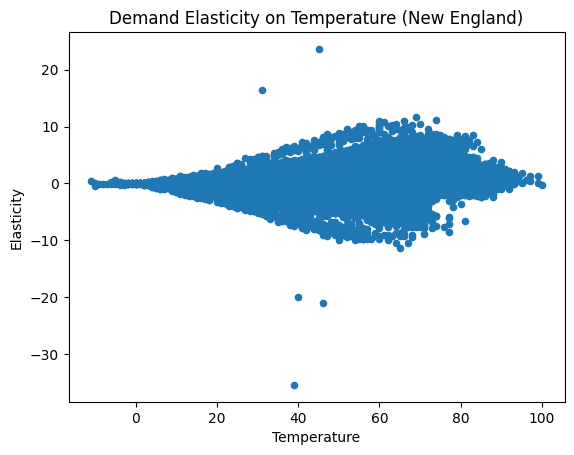

In [15]:
pct_change_dfs[0].plot.scatter('Temperature', 'Elasticity')
plt.title('Demand Elasticity on Temperature (New England)')

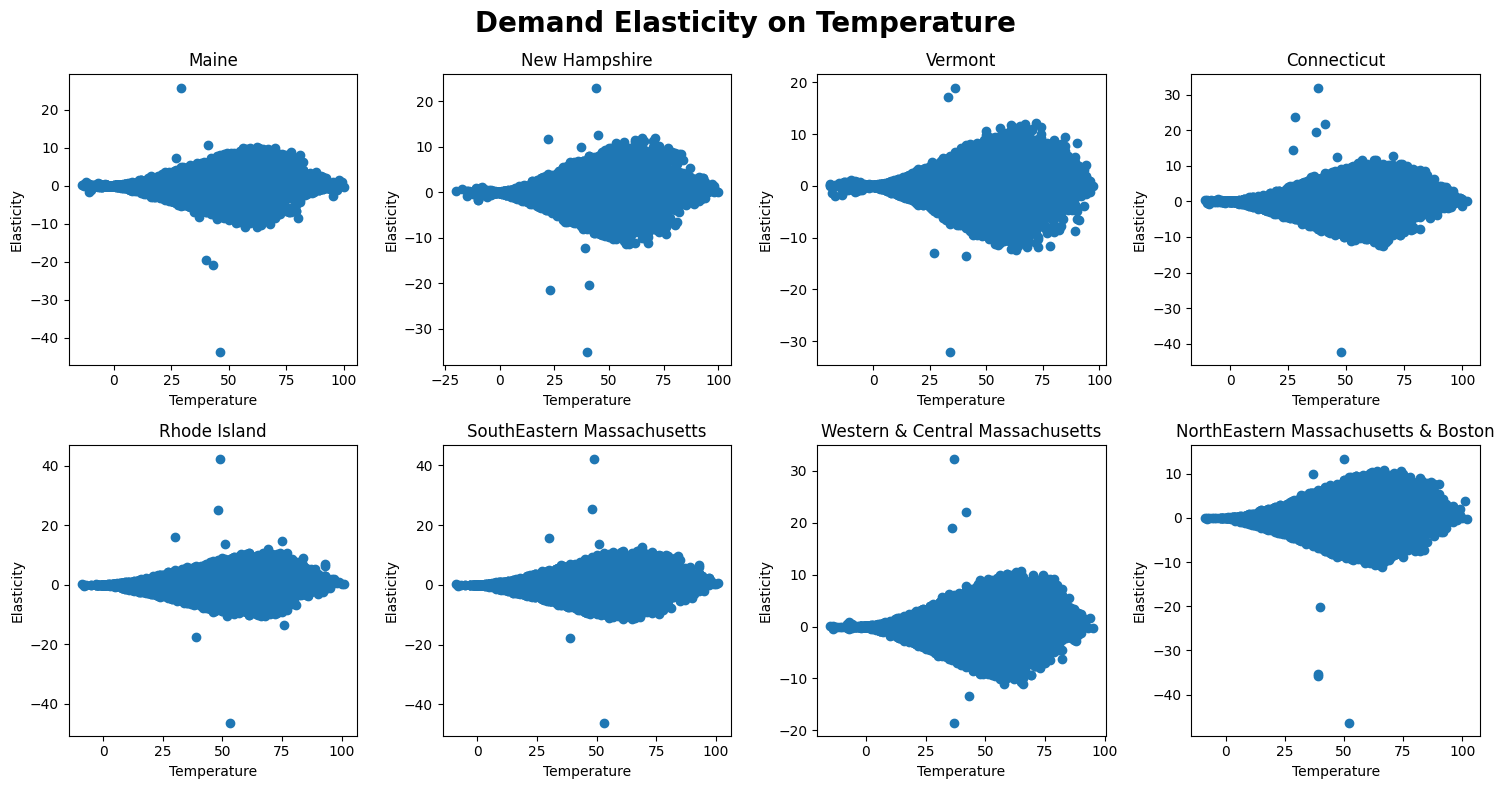

In [16]:
# Assuming `state_dfs` is a list of 8 DataFrames and `state_names` is a list of 8 titles
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(pct_change_dfs[1:], state_names_full[1:])):
    axes[i].scatter(df['Temperature'], df['Elasticity'])
    axes[i].set_title(name)
    axes[i].set_ylabel('Elasticity')
    axes[i].set_xlabel('Temperature')

fig.suptitle('Demand Elasticity on Temperature', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Running Regression